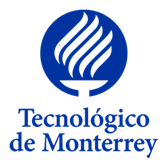

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 4

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Configuración la Base de Conocimiento y el Modelo Fundacional**

<img src="./Proyecto Integrador - RAG con Bedrock-Smart Travel Assistant KB v2.00 LangChain.drawio.png" alt="RAG Bedrock KB V1.00" />

Para crear el modelo de referencia para este proyecto se creo una base de datos de conocimientos en **AWS Bedrock**. El proceso es el siguiente:
1. Crear la base de conocimientos, o **Knowledge Base**. Para este proyecto la base de conocimiento se llama *Volindo-hotels* y se usa una base de datos de vectores de **Pinecone**
> * La fuente de conocimiento incluye más de 160 mil pares de archivos de texto y JSON con los datos de más de 145,000 hoteles. Cada par de archivos representa un hotel.
2. Cargar los datos en un Bucket de S3, llamado *hotel-clean-data*
3. Asociar el Bucket de S3 como una fuente de información para la base de conocimiento
4. Sincronizar (cargar) los datos de la fuente de información

Una vez cargado la base de conocimiento se puede probar usando la consola de AWS Bedrock o a través de APIs, tal y como se hará a continuación.

## **Probando la Base de Conocimiento y el Modelo Fundacional**

### **Preparando el Ambiente de Ejecución**

Es necesario importar las librerías necesarias para iniciar una sesión de AWS y para registrar una bitácora de ejecución.

In [1]:
!pip install langchain

In [2]:
!pip install langchain-community

In [3]:
!pip install langchain-text-splitters

In [4]:
!pip install langchain-aws

In [9]:
!pip install python-dotenv

In [10]:
!pip install pinecone-client

In [11]:
!pip install pip install renumics-spotlight

In [12]:
# Importando librerias requeridas
import time
import re
import json
import uuid
import io
import logging
import os

from dotenv import load_dotenv
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import boto3

from langchain_community.retrievers import AmazonKnowledgeBasesRetriever
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.embeddings import BedrockEmbeddings
from langchain_aws import BedrockLLM

from pinecone import Pinecone
from sklearn.metrics.pairwise import cosine_similarity
from renumics import spotlight

In [13]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
#logging.basicConfig(
#    filename='../logs/Avance4_Equipo37_Bedrock_Alternative.log',
#    level=logging.INFO,
#    format='%(asctime)s %(levelname)-8s %(message)s',
#    datefmt='%Y-%m-%d %H:%M:%S'
#)

In [59]:
# Configurando constantes para la ejecución. AWS_KBID_Vxxx contiene el identificador de la base
# de conocimientos de AWS Bedrock
load_dotenv()
MAX_ENTRIES = 100
AWS_KBID_V100 = os.environ['AWS_KBID_V100']
AWS_KBID_V200 = os.environ['AWS_KBID_V200']
PINECONE_API_KEY_V100 = os.environ['PINECONE_API_KEY_V100']
INDEX_V100 = 'volindov101'
PINECONE_API_KEY_V200 = os.environ['PINECONE_API_KEY_V200']
INDEX_V200 = 'volindov200'
KB_VERSION = '2.00'

if KB_VERSION == '1.00':
    PINDEX = INDEX_V100
    PKEY = PINECONE_API_KEY_V100
else:
    PINDEX = INDEX_V200
    PKEY = PINECONE_API_KEY_V200


### **Evaluando la Base de Conocimiento y el Modelo Fundacional Visualmente con UMAP**

AWS Bedrock provee tres tipos de mecanismos para evaluar el desempeño de los modelos fundacionales:
* Evaluación automatizada
* Evaluación por un equipo de humanos
* Evaluación por un servicio de evaluación de AWS

La evaluación automatizada permite hacer evaluaciones de la precisión del modelo, la toxicidad de las respuestas y la robustes de las respuestas. Desafortunadamente AWS solo ofrece este servicio para solo uno de los modelos de Amazon y no cubre la evaluación de la base de conocimiento y de las respuestas generadas en combinación con el modelo fundacional de Titan Text Premier.

Blah, Blah, Blah, Blah

### **Creando Agente para Recuperar Informacion de Contexto**

In [60]:
# Creando clientes para componentes de AWS Bedrock. Credenciales y configuracion se obtienen de ~/.aws
if KB_VERSION == '1.00':
    retriever = AmazonKnowledgeBasesRetriever(
        knowledge_base_id=AWS_KBID_V100,
        retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 10}},
    )
else:
    retriever = AmazonKnowledgeBasesRetriever(
        knowledge_base_id=AWS_KBID_V200,
        retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 10}},
    )

### **Creando Agente para Questionar el Modelo Fundacional**

In [61]:
model_kwargs_premier = {'temperature': 0, 'topP': 0.7, 'maxTokenCount': 3000}
llm = BedrockLLM(model_id='amazon.titan-text-premier-v1:0', model_kwargs=model_kwargs_premier)

### **Creando Función para Solictar Respuestas de AWS Bedrock y para Desplegarlas**

In [62]:
# Creando función para buscar información en la base de conocimiento y generar una respuesta usando el modelo fundacional
# Titan Text Premier de AWS Bedrock. La función también calcula el tiempo de ejecución
def retrieve_and_generate(query, retriever, llm):
    start_time = time.time()
    system_prompt = (
        "You are a friendly and helpful travel assistant. Begin your response with a polite greeting. Accurately use the detailed context provided from the database "
        "to answer the following query, particularly focusing on correct location details. Ensure the locations mentioned are verified against "
        "the context. Provide options within the same city or nearby, double-checking location accuracy. Offer two or three choices when possible. "
        "Address the user by name if provided in the context. If the answer is unknown or if you cannot verify the location details, state 'I don't know'. "
        "Limit responses to three sentences and maintain conciseness. "
        "Context: {context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    chain = create_retrieval_chain(retriever, question_answer_chain)
    
    response = chain.invoke({"input": query})
    elapsed_time = time.time() - start_time
    return elapsed_time, response


In [63]:
# Creando función desplegar la respuesta recibida de AWS. La respuesta incluye diferentes valores como la respuesta completa,
# la respuesta en partes, o citas, con referencias y los metadatos de cada referencia
def display_response(response, elapsed_time):
    # desplegando respuestas
    print(f"Respuesta despues de {elapsed_time:.4f} segundos:\n{response['answer']}")
#    for context in response['context']:
#        print(f"\nContexto:\n{context.page_content}")
#        print(f"\nCalificacion:{context.metadata['score']:.6f}")
#        print(f"\nNombre del hotel: {context.metadata['source_metadata']['Name']}, Ciudad:{context.metadata['source_metadata']['City']}, Direccion:{context.metadata['source_metadata']['Address']}")
#        print(f"\nPais: {context.metadata['source_metadata']['Country']}, Continente:{context.metadata['source_metadata']['Continent']}, URI:{context.metadata['source_metadata']['x-amz-bedrock-kb-source-uri']}")


In [64]:
def prepare_emb_space(query, answer, country, index_name, key, entries=1000):
    # Preparando modelo de embeddings de AWS Bedrock Titan Embed Text v1.x
    embeddings = BedrockEmbeddings(model_id='amazon.titan-embed-text-v1')
    
    # Generando un dataframe con embeddings para la pregunta
    query_emb = embeddings.embed_query(query)
    query_emb_df = pd.DataFrame({'id': 'query','query': query,'embeddings': [query_emb]})
    
    # Generando un dataframe con embeddings para la respuesta
    answer_emb = embeddings.embed_query(answer)
    answer_emb_df = pd.DataFrame({'id': 'answer','answer': answer,'embeddings': [answer_emb]})

    # Creando cliente de Pinecone
    pc = Pinecone(api_key=key)
    
    # Recuperando registros del índice de Pinecone para un país en especifico
    index = pc.Index(index_name)
    emb_space = index.query(
        vector=query_emb,
        top_k=entries,
        include_values=True,
        include_metadata=True,
        filter={
            "Country": {"$eq": country}
        }
    )

    # Creando un dataframe con los datos recuperados del índice de Pinecone
    emb_space_df = pd.DataFrame(columns=['id', 'source', 'score', 'document', 'embeddings'])
    for match in emb_space.matches:
        id = match.id
        source = match.metadata['x-amz-bedrock-kb-source-uri']
        score = match.score
        document = match.metadata['hotel-data']
        embeddings = match.values
        emb_space_df = pd.concat(
            [
                emb_space_df,
                pd.DataFrame({'id': id, 'source': source, 'score': score, 'document': document, 'embeddings': [embeddings]})
            ],
            ignore_index=True
        )

    # Creando un dataframe con los registros para la pregunta, la respuesta y los datos
    # recuperados de Pinecone
    emb_space_df = pd.concat([query_emb_df, answer_emb_df, emb_space_df])

    # Calculando la distancia de coseno para cada registro
    emb_space_df['distance'] = emb_space_df.apply(
        lambda row: 1 - (
            np.dot(row['embeddings'], answer_emb) / (np.linalg.norm(row['embeddings']) * np.linalg.norm(answer_emb))
        ),
        axis=1
    )

    return emb_space_df


### **Ejecutando la Evaluación**

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [65]:
input = '''Can you suggest accomodation near pilanesberg national park in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 7.5442 segundos:
Sure thing! Here are some options:
- Tshukudu Bush Lodge
- Bakubung Bush Lodge
- Kwa Maritane Bush Lodge
- Black Rhino Game Lodge
- The Kingdom Resort
- Shepherd's Tree Game Lodge
- Sun City Resort
- Pilanesberg Private Lodge
- Manyane Resort
- Bakgatla Resort

These are all located near the Pilanesberg National Park in South Africa. Let me know if you need more information about any of these options!


**Evaluación**

In [66]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'South Africa',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [67]:
input = '''Can you suggest accomodation near pilanesberg national park in the north west province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 11.9932 segundos:
Hello! I'd be happy to help you find accommodations near Pilanesberg National Park in the North West Province of South Africa. Here are a few options for you to consider:

1. Tshukudu Bush Lodge - This 4-star lodge is located within Pilanesberg National Park and offers luxurious accommodations with private balconies and fireplaces. Guests can enjoy a complimentary buffet breakfast, a restaurant, a bar, and a poolside bar.

2. Nkala Safari Lodge - This 4.5-star lodge is also located within Pilanesberg National Park and offers air-conditioned rooms with kitchens, flat-screen TVs, and complimentary Wi-Fi. Guests can enjoy a bar and a terrace with views of the surrounding bush.

3. Bakubung Bush Lodge - This 4-star lodge is located just outside Pilanesberg National Park and offers spacious rooms with private balconies, a restaurant, a bar, and an outdoor pool. Guests can enjoy game drives, bush walks, and birdwatching.

4. Kwa Maritane Bush Lodge - Th

**Evaluación**


In [69]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'South Africa',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [70]:
input = '''What attractions are close to Black Rhino Game Lodge, north west province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 60.9077 segundos:
Hi there! The Black Rhino Game Lodge is located in Pilanesberg National Park, which is a popular destination for wildlife enthusiasts. Within the park, you can explore various game drives and safaris to spot the Big Five (lions, leopards, rhinos, elephants, and buffalos) and other wildlife. Additionally, the nearby Sun City Resort offers a range of attractions, including casinos, golf courses, water parks, and entertainment venues. If you're interested in cultural experiences, you can visit the Pilanesberg Centre, which provides information about the park's history, ecology, and conservation efforts. Overall, the area offers a mix of wildlife, adventure, and relaxation options to suit different interests.


**Evaluación**


In [71]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'South Africa',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [72]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 12.4944 segundos:
Hello! I'd be happy to help you find accommodation in Cape Town, Western Cape Province, South Africa. Here are some options for you:

1. Cape Village Lodge - This 4-star guesthouse is located in Cape Town (Welgemoed) and is within a 5-minute drive of Durbanville Golf Club and Nitida Cellars.
2. This cottage - This 5-star cottage is located in Cape Town (Cape Town City Centre) and is within a 10-minute drive of Table Mountain and South African National Gallery.
3. This apartment - This 4-star apartment is located in Cape Town (Cape Town City Centre) and is within a 10-minute walk of Kloof Street and Table Mountain National Park.
4. This vacation home - This 4.5-star vacation home is located in Cape Town (Cape Town City Centre) and is within a 5-minute walk of Greenmarket Square and Table Mountain National Park.
5. This apartment - This 4-star apartment is located in Cape Town (Cape Town City Centre) and is within a 5-minute drive of Castle of Good 

**Evaluación**


In [73]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'South Africa',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [74]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa, minimum rating of 4?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 10.3708 segundos:
Hello! I'd be happy to help you find accommodation in Cape Town, Western Cape Province, South Africa with a minimum rating of 4. Here are some options for you:

1. Cape Village Lodge in Cape Town (Welgemoed) - 4-star guesthouse
2. This apartment in Cape Town (Cape Town City Centre) - 4-star apartment
3. This apartment in Cape Town (Cape Town City Centre) - 4-star apartment
4. This apartment in Cape Town (Cape Town City Centre) - 4-star apartment
5. This apartment in Cape Town (Cape Town City Centre) - 4-star apartment
6. This apartment in Cape Town (Cape Town City Centre) - 4-star apartment
7. This apartment in Cape Town (Cape Town City Centre) - 4-star apartment
8. This apartment in Cape Town (Cape Town City Centre) - 4-star apartment
9. This vacation home in Cape Town (Cape Peninsula) - 4-star vacation home
10. This cottage in Cape Town (Cape Peninsula) - 4-star cottage
11. This apartment in Cape Town (Camps Bay) - 4-star apartment
12. This apar

**Evaluación**


In [76]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'South Africa',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [77]:
input = '''Can you suggest accommodation in Hoedspruit, limpopo province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 11.8143 segundos:
Hello! I'd be happy to help you find accommodation in Hoedspruit, Limpopo Province, South Africa. Here are some options for you:

1. Twiga Travel: This 4-star lodge is located in Hoedspruit and is 13.2 mi (21.2 km) from Jessica the Hippo and 15.1 mi (24.2 km) from Hoedspruit Endangered Species Centre.
2. Private Vacation Home: This 4-star vacation home is located in Hoedspruit and is within a 5-minute drive of Hoedspruit Wildlife Estate. It is 5.8 mi (9.4 km) from Greater Kruger National Park and 11.9 mi (19.2 km) from Jessica the Hippo.
3. Private Vacation Home: This 4-star vacation home is located in Hoedspruit and is in the mountains, a 4-minute drive from Hoedspruit Wildlife Estate and 11 minutes from Kapama Game Reserve. It is 5.6 mi (9.1 km) from Balule Game Reserve and 12.2 mi (19.6 km) from Jessica the Hippo.

Please note that the third option will be closed for renovations from April 24, 2021, to January 31, 2023.

Let me know if you have

**Evaluación**


In [78]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'South Africa',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [79]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 10.6289 segundos:
Hello! I'd be happy to help you find a place to stay in Monterrey, Nuevo Leon. Here are five options for you:

1. Auténtico Monterrey: This 4-star hotel is located in San Pedro Garza García, within a 10-minute drive of Fundidora Park and Paseo San Pedro. It offers comfortable guest rooms with modern amenities, a swimming pool, and a restaurant.

2. NH Monterrey La Fe: This 4-star hotel is centrally located in San Nicolas de los Garza, within a 10-minute drive of Fundidora Park and Paseo La Fe. It offers air-conditioned rooms with minibars and flat-screen TVs, a restaurant, and a bar.

3. Hotel Cinco Monteria: This hotel is located in Montería, Colombia, not in Monterrey, Mexico. However, I'll include it here for reference. It offers a restaurant, a rooftop terrace with a hot tub, and free WiFi access.

4. Real Inn Nuevo Morelos: This hotel is located in Nuevo Morelos and features a garden, a bar, and a terrace. It offers air-conditioned rooms with

**Evaluación**


In [80]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'Mexico',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [81]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico, near Tec de Monterrey?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 5.3668 segundos:
Hello! Here are five places to stay in Monterrey, Nuevo Leon, Mexico, near Tec de Monterrey:
1. Hyatt Place Monterrey Valle
2. NH Monterrey La Fe
3. Quinta Real Monterrey
4. Smart Hotel Cintermex
5. Novotel Monterrey Valle

I hope this helps! Let me know if you have any other questions.


**Evaluación**


In [82]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'Mexico',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [83]:
input = '''I want to stay with my wife for a romantic weekend in Mexico City. We want to have a nice massage within the hotel.'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 6.0281 segundos:
Hello! I'm happy to help you find the perfect hotel for your romantic weekend in Mexico City. Marquis Reforma Hotel Spa is a 4.5-star hotel that offers spa services, including massages. It is located in the city center, close to Chapultepec Park and the Angel of Independence Monument. Another option is Hotel Spa Sitio Sagrado, which is located in the outskirts of Tepoztlán, a Magic Village. It offers an outdoor pool, a restaurant, and a bar, as well as spa services. Let me know if you would like to know more about these hotels or if you want to explore other options.


**Evaluación**


In [84]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'Mexico',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [85]:
input = '''I want to do a a golf weekend with my friends in Cancun. What hotels do you recommend that have their own golf course?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 7.1317 segundos:
Hi! I'm happy to help you find the perfect hotel for your golf weekend in Cancun. Here are some options that have their own golf course:

- The Villa du Golf à Cancun Hotel Boutique is located in the exclusive Golf Course of Pok-ta-Pok in Cancun's hotel zone.
- The Dreams Vista Cancun Golf & Spa Resort - All Inclusive is located near the Puerto Cancun Golf Course.
- The Wyndham Grand Cancun All Inclusive Resort & Villas is located near the Iberostar Cancun Golf Course.

Let me know if you have any questions about these hotels or if you would like to see more options!


**Evaluación**


In [86]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'Mexico',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [87]:
input = '''Can you recommend hotels near Ueno Park in Tokyo?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 6.3769 segundos:
Hello! I'd be happy to help you find hotels near Ueno Park in Tokyo. Here are some options:

1. Mitsui Garden Hotel Ueno Tokyo - This 4-star hotel is just 0.3 miles (0.5 km) from Ueno Park.
2. Candeo Hotels Uenokoen - Another 4-star hotel, Candeo Hotels Uenokoen is also located near Ueno Park.

Both hotels offer comfortable rooms and convenient amenities. Let me know if you need more information about either of these options!


**Evaluación**


In [88]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'Japan',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [89]:
input = '''Can you recommend hotels in Hakone Japan? Ideally I am looking for traditional japanese ryokans.'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 19.2539 segundos:
Hello! I'd be happy to help you find a hotel in Hakone, Japan. Here are some traditional Japanese ryokans you might like:

1. Hakone Tokinoshizuku - This ryokan offers 5-star accommodation with private balconies, a restaurant, a 24-hour front desk, and free WiFi. It also features a hot spring bath, spa facilities, and an open-air bath.

2. Gyokutei Ryokan - This ryokan is located atop a hill in Hakone and offers an authentic Japanese accommodation with an indoor hot spring bath. It also has a garden, luggage storage space, and a massage service.

3. Hakone Yuyado Zen - This adults-only ryokan offers a garden, a bar, a shared lounge, a restaurant, an open-air bath, a hot spring bath, and a spa facility. It also has a sun terrace and free WiFi.

4. Shiunso Ryokan - This ryokan is located next to Hayakawa River and offers luxurious Japanese accommodation with natural hot-spring baths. It also has traditional multi-course meals and rooms with private 

**Evaluación**


In [90]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'Japan',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [91]:
input = '''Can you recommend hotels in Chihuauha that are located near Periferico de la Juventud?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)


Respuesta despues de 8.1313 segundos:
I'm sorry, but I don't have enough information to provide hotel recommendations in Chihuahua near Periferico de la Juventud. However, I can suggest some hotels in Chihuahua that you might find interesting:

1. Quinta Real Chihuahua: This hotel is located in the heart of Chihuahua and offers luxurious accommodations, a spa, and a fitness center.
2. City Express Chihuahua: This hotel is located near the city center and offers modern rooms, a fitness center, and a business center.
3. Hotel Colonial Chihuahua: This hotel is located in the historic center of Chihuahua and offers traditional Mexican decor, a restaurant, and a bar.
4. Hotel Lucerna Chihuahua: This hotel is located near the airport and offers spacious rooms, a fitness center, and a pool.
5. Hotel Plaza Chihuahua: This hotel is located in the city center and offers comfortable rooms, a restaurant, and a bar.

I hope this helps! Let me know if you have any other questions.


**Evaluación**


In [92]:
emb_space = prepare_emb_space(
    input,
    response['answer'],
    'Mexico',
    PINDEX,
    PKEY,
    MAX_ENTRIES
)
spotlight.show(emb_space)


/var/folders/cy/k7rk55bs57sg43vmv400yd_r0000gp/T/ipykernel_3741/1787413403.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  emb_space_df = pd.concat(


## **Conclusiones**


El análisis de la evaluación se encuentra en el archivo ***Proyecto-Integrador-Evaluacion-Avance4.xlsx*** en el mismo repositorio de esta libreta.

La presentación de los nuevos modelos y la selección del mejor modelo se encuentran en el archivo ***Avance4 Smart Travel Assistant-Reporte de Progreso-02.pptx*** en el mismo repositorio de esta libreta.

## **Referencias**

* Monigatti, L. (2023, 6 de diciembre). A Guide on 12 Tuning Strategies for Production-Ready RAG Applications. Medium. https://towardsdatascience.com/a-guide-on-12-tuning-strategies-for-production-ready-rag-applications-7ca646833439

* AWS. (2023, 28 de noviembre). Knowledge Bases now delivers fully managed RAG experience in Amazon Bedrock - Amazon Web Services.  Amazon Web Services. https://aws.amazon.com/es/blogs/aws/knowledge-bases-now-delivers-fully-managed-rag-experience-in-amazon-bedrock/

* Monigatti, L. (2023, 15 de deciembre). Evaluating RAG Applications with RAGAs. Medium. https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a

* Grech, C. (2024, 16 de febrero). Evaluating RAG Performance: A Comprehensive Guide. Medium. https://christiangrech.medium.com/evaluating-rag-performance-a-comprehensive-guide-b1d8f903b7ad

* AWS (s.f.). Amazon Titan Text models - Amazon Bedrock. docs.aws.amazon.com. Recuperado 20 de mayo 26, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html

* LangChain. (s.f.). Bedrock (Knowledge Bases). python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/retrievers/bedrock/

* LangChain. (s.f.). ChatBedrock. python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/chat/bedrock/

* LangChain. (s.f.). langchain.chains.retrieval_qa.base.RetrievalQA LangChain 0.1.12. api.python.langchain.com. https://api.python.langchain.com/en/latest/chains/langchain.chains.retrieval_qa.base.RetrievalQA.html

* McInnes, L., Healy, J., & Melville, J. (2020, 17 de septiembre). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. ArXiv.org. https://doi.org/10.48550/arXiv.1802.03426

* Renumics. (s.d.). spotlight. renumics.com. Recuperado 27 de mayo, 2024, from https://renumics.com/api/spotlight
